## **1. Setup and Data Loading**

### **1.1 Import Libraries**

The following libraries are used for data manipulation, visualization, statistical testing, and machine learning.

In [208]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [209]:
import warnings
warnings.filterwarnings("ignore")

### **1.2 Load Dataset**

The synthetic dataset (rice_synthetic_data.csv) is loaded for analysis.

In [210]:
# Load the dataset
data_path = "data/rice_cultivation_daily_dataset.csv"
test_data_path = "data/Weather_Suitability_test.csv"
df = pd.read_csv(data_path)
test_df = pd.read_csv(test_data_path)
df.head()

,season,average_day_temp,average_night_temp,daily_sunshine_hours,daily_rainfall,suitability
0,kharif,28.6,21.3,7.572613,13.114609,suitable
1,rabi,25.9,21.5,5.692076,0.000000,not suitable
2,rabi,26.0,19.9,11.612907,0.000000,not suitable
3,kharif,27.1,20.2,8.504957,22.802553,suitable
4,pre-kharif,25.7,22.5,7.830067,5.836964,suitable


## **2. Exploratory Data Analysis (EDA)**

## **2.1 Data Overview**

Examine the dataset’s structure and summary statistics.

In [211]:
# Observe the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                10000 non-null  object 
 1   average_day_temp      10000 non-null  float64
 2   average_night_temp    10000 non-null  float64
 3   daily_sunshine_hours  10000 non-null  float64
 4   daily_rainfall        10000 non-null  float64
 5   suitability           10000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 468.9+ KB


In [212]:
# Observe the data statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_day_temp,10000.0,27.781290,3.265903,15.500000,25.600000,27.800000,29.800000,42.500000
average_night_temp,10000.0,21.238280,1.630434,14.900000,20.200000,21.200000,22.300000,30.000000
daily_sunshine_hours,10000.0,7.852937,1.932276,0.720779,6.499464,7.742585,9.185826,12.000000
daily_rainfall,10000.0,5.353893,7.620658,0.000000,0.000000,0.000000,9.890116,63.413649


### **2.2 Data Distribution**

Visualize numerical and categorical features to understand distributions.

- **Numerical Features**: Histograms with kernel density estimation (KDE) for continuous variables.

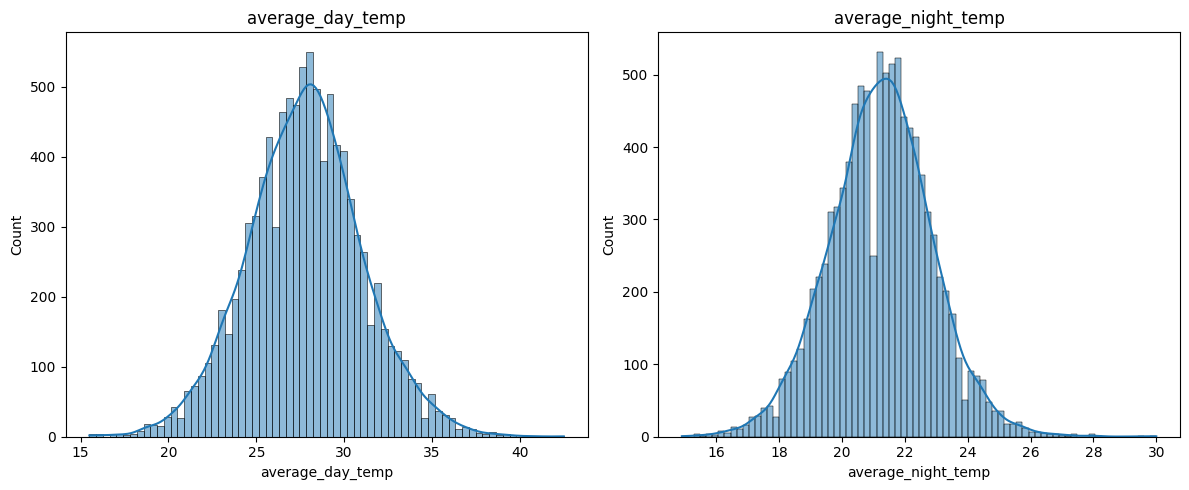

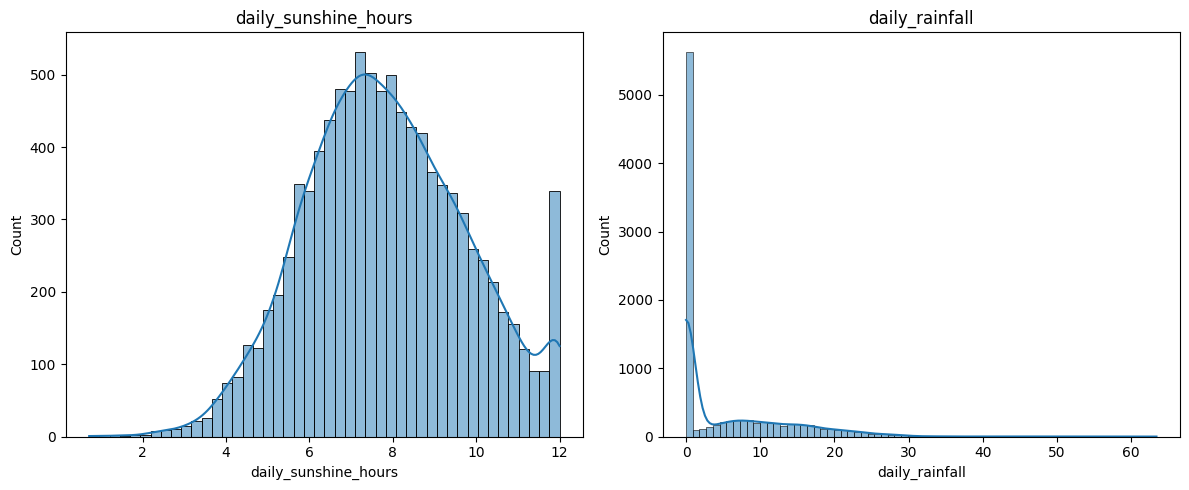

In [213]:
def plot_histogram_two_columns(df):
    numerical_columns = df.select_dtypes(include='number').columns
    for i in range(0, len(numerical_columns), 2):  # Iterate in steps of 2
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1-row, 2-column layout
        axes = axes.flatten()
        for j, column in enumerate(numerical_columns[i:i+2]):  # Plot up to 2 columns at a time
            sns.histplot(df[column], ax=axes[j], kde=True)
            axes[j].set_title(column)
        # Hide any unused subplot (if there are fewer than 2 columns in the last iteration)
        if len(numerical_columns[i:i+2]) < 2:
            axes[1].axis('off')
        plt.tight_layout()
        plt.show()

# Call the function to plot histograms
plot_histogram_two_columns(df)

- **Categorical Features:** Count plots for categorical variables.

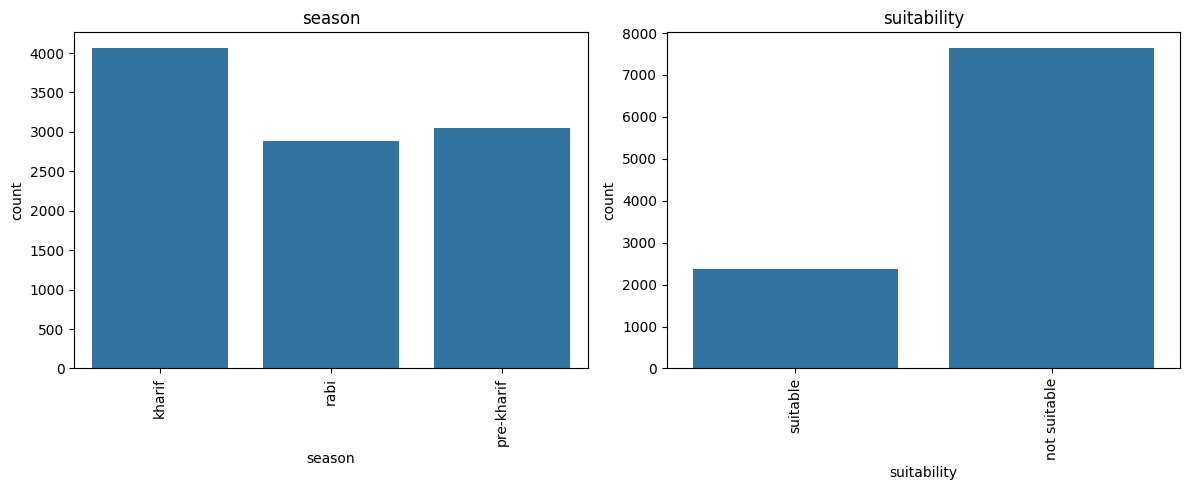

In [214]:
def plot_countplot(df):
    categorical_columns = df.select_dtypes(include='object').columns
    fig, axes = plt.subplots(int(np.ceil(len(categorical_columns) / 2)), 2, figsize=(12, 5))
    axes = axes.flatten()
    for i, column in enumerate(categorical_columns):
        sns.countplot(x=df[column], ax=axes[i])
        axes[i].set_title(column)
        axes[i].tick_params(axis='x', rotation=90)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_countplot(df)

## **3. Data Cleaning**

### **3.1 Missing Values**

Check for missing values in the dataset.

In [215]:

# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing values found in the following columns:")
    print(missing_values)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


### **3.2 Duplicates**

Identify and report duplicate rows.

In [216]:
# Check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Duplicate rows found: {duplicates}")
else:
    print("No duplicate rows found in the dataset.")

Duplicate rows found: 1


In [217]:
# Remove duplicates
df.drop_duplicates(inplace=True)

### **3.3 Outliers**

Visualize and remove outliers using the Interquartile Range (IQR) method.

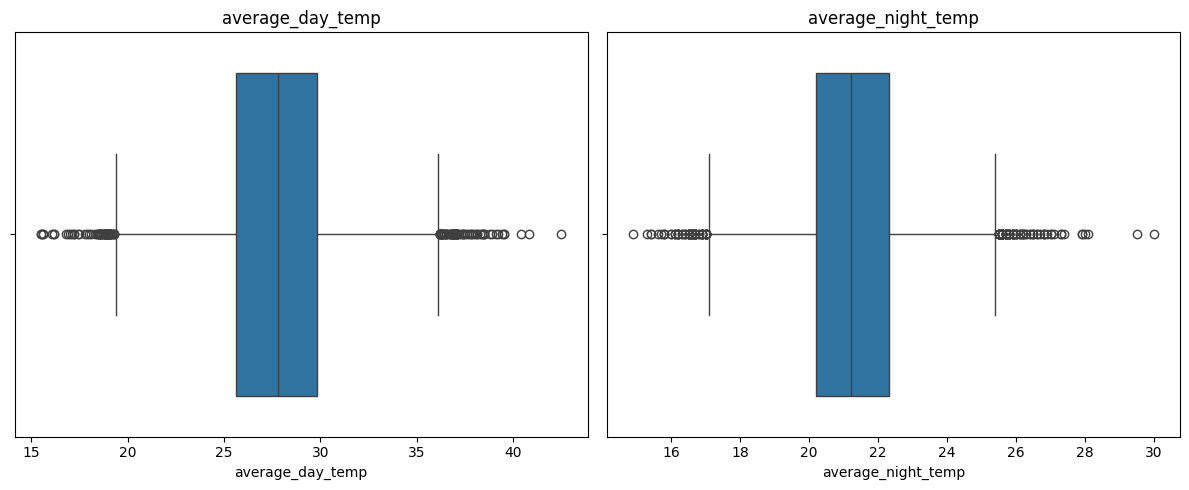

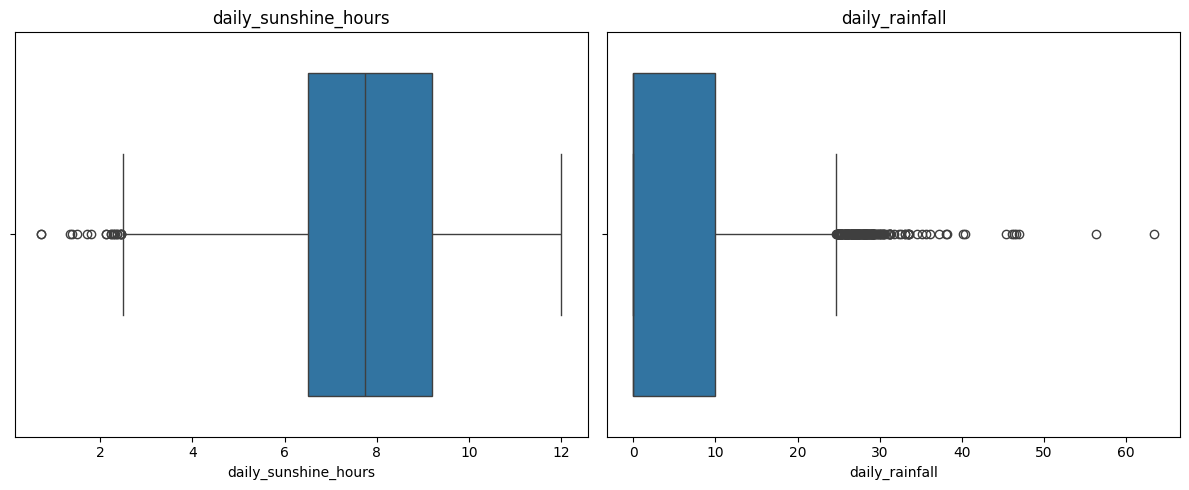

In [218]:
# Check for outliers and visualize them (two boxplots at a time)
def plot_boxplot_two_columns(df):
    numerical_columns = df.select_dtypes(include='number').columns
    for i in range(0, len(numerical_columns), 2):  # Iterate in steps of 2
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1-row, 2-column layout
        axes = axes.flatten()
        for j, column in enumerate(numerical_columns[i:i+2]):  # Plot up to 2 columns at a time
            sns.boxplot(x=df[column], ax=axes[j])
            axes[j].set_title(column)
        # Hide any unused subplot (if there are fewer than 2 columns in the last iteration)
        if len(numerical_columns[i:i+2]) < 2:
            axes[1].axis('off')
        plt.tight_layout()
        plt.show()

# Call the function to plot boxplots
plot_boxplot_two_columns(df)

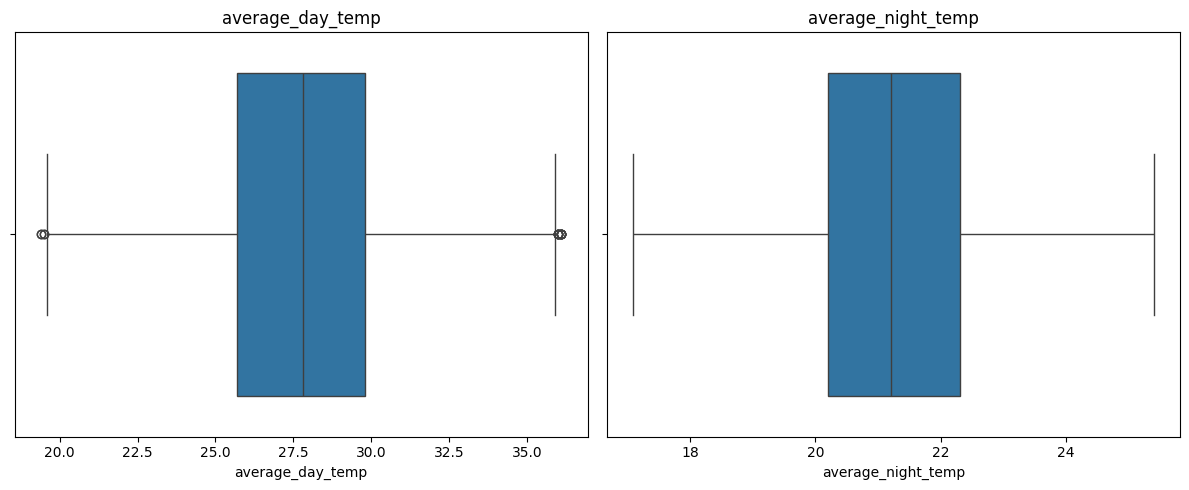

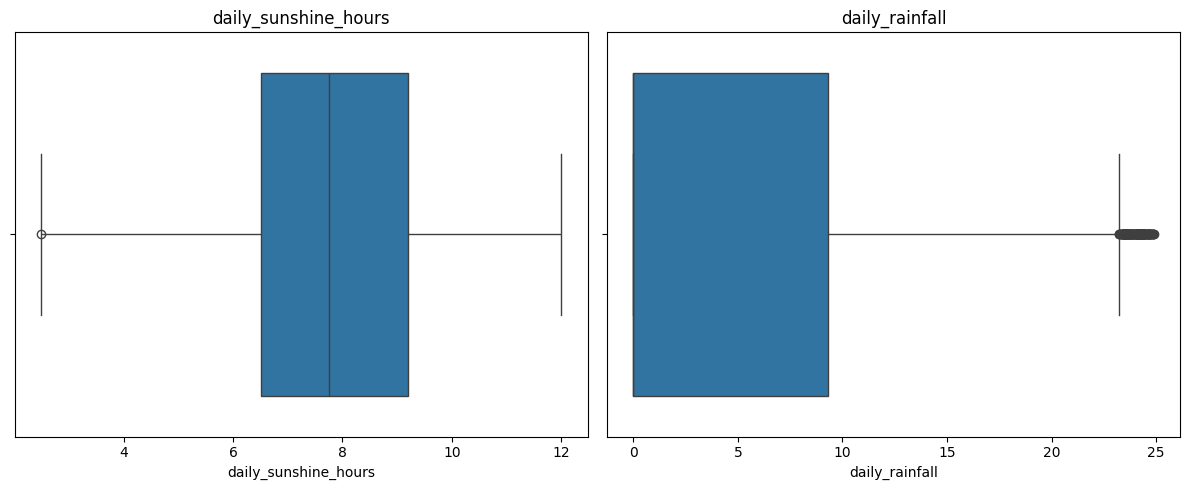

In [219]:
# Remove outliers using IQR method
def remove_outliers_iqr(df):
    numerical_columns = df.select_dtypes(include='number').columns
    # Remove the target variable from the list of numerical columns
    target_variable = 'suitability'  # Replace with your actual target variable name
    if target_variable in numerical_columns:
        numerical_columns = numerical_columns[numerical_columns != target_variable]
    # Calculate IQR and remove outliers
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_no_outliers = remove_outliers_iqr(df)
plot_boxplot_two_columns(df_no_outliers)

## **4. Feature Engineering**

### **4.1 Multicollinearity**

Assess correlations between numerical features to identify multicollinearity.

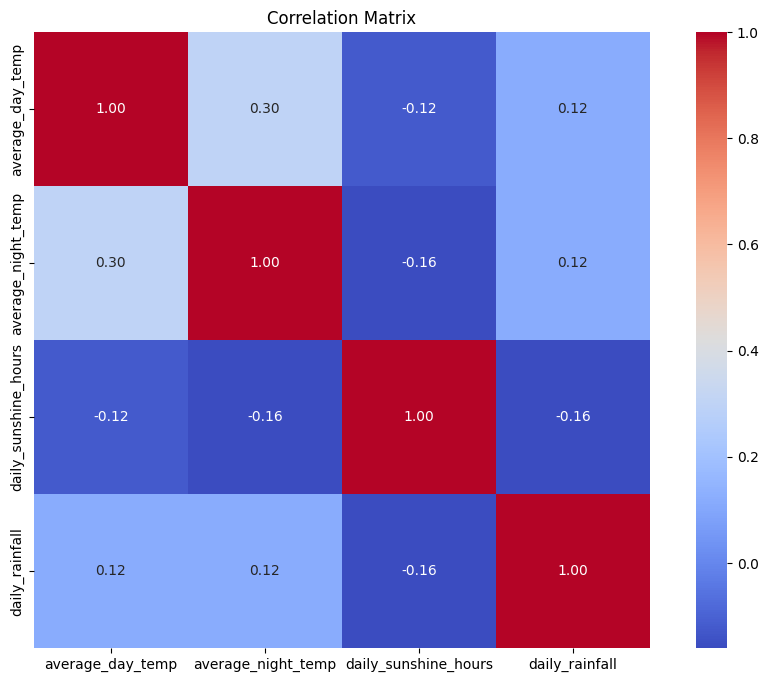

In [220]:
# Check for multicollinearity
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr(numeric_only=True)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()
plot_correlation_matrix(df_no_outliers)

### **4.2 Class Imbalance**

Check the distribution of the target variable (suitability).

In [221]:
# Check for class imbalance
df_no_outliers['suitability'].value_counts()

suitability
not suitable    7243
suitable        2266
Name: count, dtype: int64

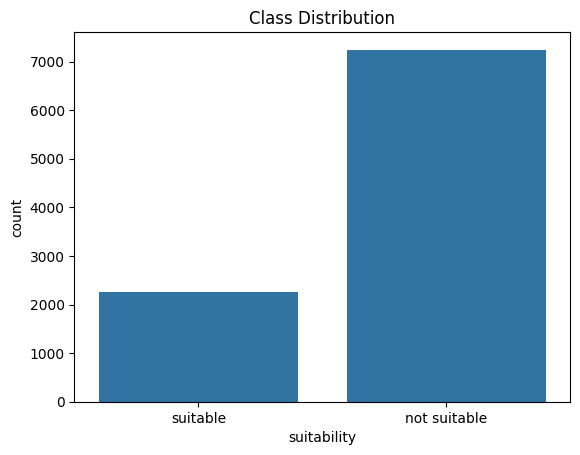

In [222]:
# Plot class distribution
def plot_class_distribution(df):
    target_column = 'suitability'  # Replace with your target column name
    sns.countplot(x=df[target_column])
    plt.title('Class Distribution')
    plt.show()
plot_class_distribution(df_no_outliers)

### **4.3 Encode Categorical Variables**

Convert categorical variables to numerical codes.

In [223]:
numerical_columns = df_no_outliers.select_dtypes(include='number').columns
categorical_columns = df_no_outliers.select_dtypes(include='object').columns
print("Number of numerical columns:", len(numerical_columns))
print("Numerical columns:", numerical_columns)
print("Number of categorical columns:", len(categorical_columns))
print("Categorical columns:", categorical_columns)

Number of numerical columns: 4
Numerical columns: Index(['average_day_temp', 'average_night_temp', 'daily_sunshine_hours',
       'daily_rainfall'],
      dtype='object')
Number of categorical columns: 2
Categorical columns: Index(['season', 'suitability'], dtype='object')


In [224]:
# Encode categorical variables using LabelEncoder
def encode_categorical_variables(df):
    df['season'] = df['season'].replace({'pre-kharif': 0, 'kharif': 1, 'rabi': 2})
    df['suitability'] = df['suitability'].replace({'suitable': 1, 'not suitable': 0})
    return df
df_encoded = encode_categorical_variables(df_no_outliers)
test_df_encoded = encode_categorical_variables(test_df)

In [225]:
df_encoded

,season,average_day_temp,average_night_temp,daily_sunshine_hours,daily_rainfall,suitability
0,1,28.6,21.3,7.572613,13.114609,1
1,2,25.9,21.5,5.692076,0.000000,0
2,2,26.0,19.9,11.612907,0.000000,0
3,1,27.1,20.2,8.504957,22.802553,1
4,0,25.7,22.5,7.830067,5.836964,1
...,...,...,...,...,...,...
9995,2,27.2,21.0,8.047391,4.746659,1
9996,2,24.2,19.6,10.716155,0.000000,0
9997,2,26.6,19.2,10.895600,0.000000,0
9998,1,29.9,20.0,7.960959,0.000000,0


## **5. Data Preprocessing**

### **5.1 Separate Features and Target**

Split the dataset into features (X) and target (y).

In [226]:
# Separate features and target
X = df_encoded.drop('suitability', axis=1)
y = df_encoded['suitability']

real_X = test_df_encoded.drop('suitability', axis=1)
real_y = test_df_encoded['suitability']

print("Shape of Features:", X.shape)
print("Shape of Target:", y.shape)

Shape of Features: (9509, 5)
Shape of Target: (9509,)


### **5.2 Handle Class Imbalance**

Use SMOTE to oversample the minority class.

In [227]:
# Upsample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
real_X, real_y = smote.fit_resample(real_X, real_y)
# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
suitability
1    7243
0    7243
Name: count, dtype: int64


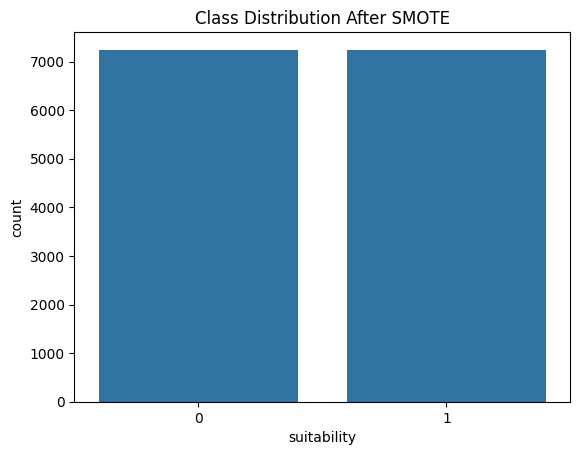

In [228]:
# Visualize the class distribution after SMOTE
def plot_class_distribution_after_smote(y_resampled):
    sns.countplot(x=y_resampled)
    plt.title('Class Distribution After SMOTE')
    plt.show()
plot_class_distribution_after_smote(y_resampled)

### **5.3 Scale Features**

Standardize features to ensure consistent scales.

In [229]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
real_X_test = scaler.fit_transform(real_X)
real_y_test = real_y

# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
print("Shape of Training Data:", X_train.shape)
print("Shape of Testing Data:", X_test.shape)

Shape of Training Data: (11588, 5)
Shape of Testing Data: (2898, 5)


## **6. Model Training and Evaluation**

### **6.1 Train Multiple Models**

Evaluate a range of classifiers: Logistic Regression, SVM, KNN, Random Forest, Gradient Boosting, XGBoost, and LightGBM.

In [230]:
# Define a dictionary of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(verbose=-1)
}

results = []  # List to store performance metrics for each model

trained_models = {}

# Train each model and evaluate its performance
for name, model in models.items():
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Use predict_proba to calculate ROC AUC if available
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    trained_models[name] = model

    # Print performance metrics
    print(f"Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC AUC  : {roc_auc:.4f}")
    else:
        print("  ROC AUC  : Not available")
    print("-" * 40)

    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Store the results in a dataframe and print
results_df = pd.DataFrame(results)
print("Summary of model performance:")
print(results_df)

# Save the model results
results_df.to_csv('base_model_performance.csv', index=False)

Model: Logistic Regression
  Accuracy : 0.8492
  Precision: 0.8538
  Recall   : 0.8376
  F1 Score : 0.8456
  ROC AUC  : 0.9107
----------------------------------------
Model: SVM
  Accuracy : 0.9793
  Precision: 0.9730
  Recall   : 0.9853
  F1 Score : 0.9791
  ROC AUC  : 0.9989
----------------------------------------
Model: KNN
  Accuracy : 0.9762
  Precision: 0.9620
  Recall   : 0.9909
  F1 Score : 0.9762
  ROC AUC  : 0.9932
----------------------------------------
Model: Random Forest
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000
  ROC AUC  : 1.0000
----------------------------------------
Model: XGBoost
  Accuracy : 0.9997
  Precision: 1.0000
  Recall   : 0.9993
  F1 Score : 0.9996
  ROC AUC  : 0.9996
----------------------------------------
Model: LightGBM
  Accuracy : 0.9997
  Precision: 0.9993
  Recall   : 1.0000
  F1 Score : 0.9997
  ROC AUC  : 1.0000
----------------------------------------
Summary of model performance:
                 Model 

### **6.2 Visualize Model Performance**

Compare model performance across metrics.

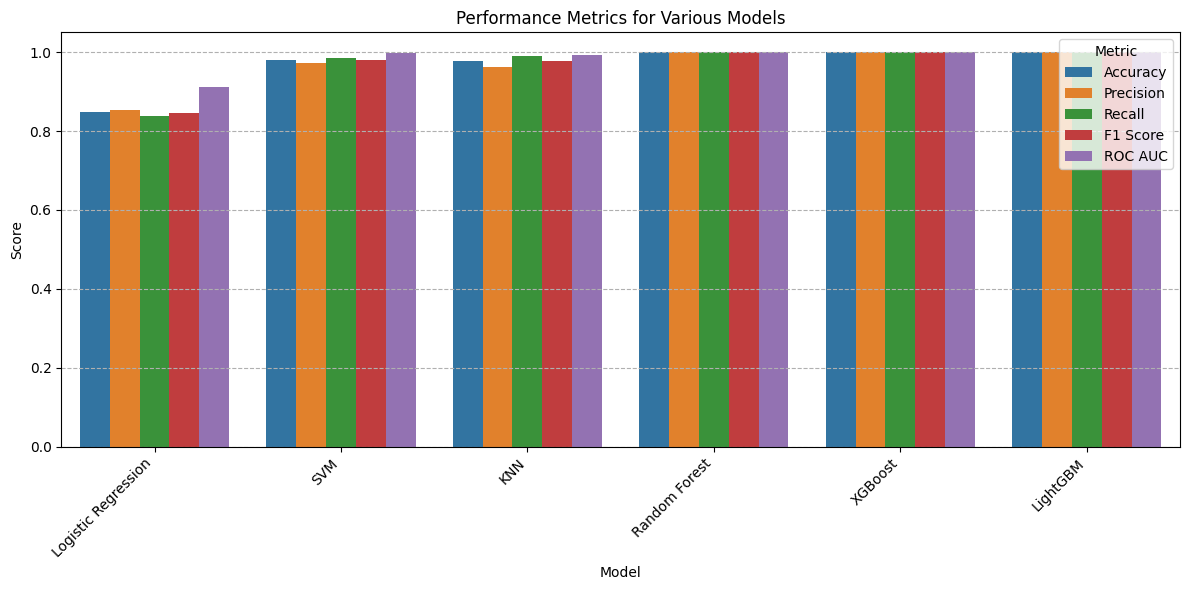

In [231]:
# Plot the performance metrics
# Melt the results_df so that each row represents a metric score for a given model
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('figures/base_model_performance.png')
# Show the plot
plt.show()

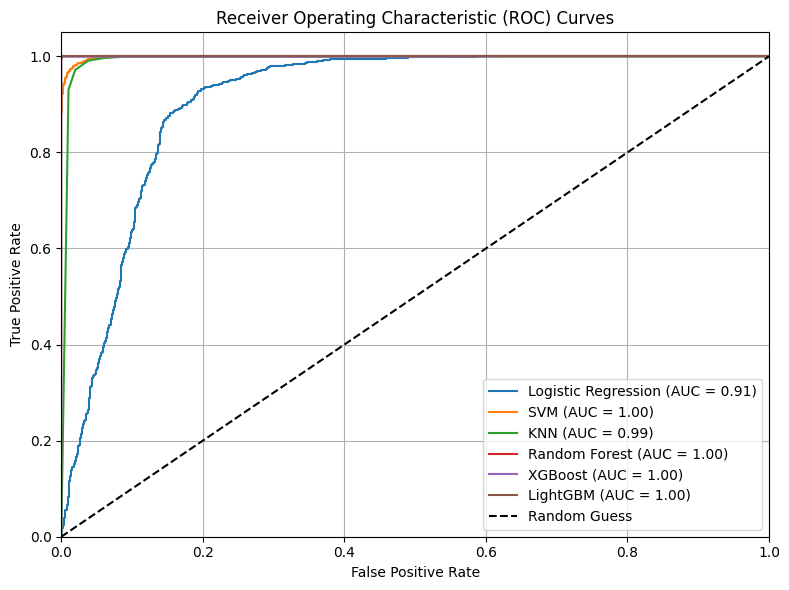

In [232]:
# Plot ROC curve for all models in one figure
def plot_roc_curves(y_test, models, X_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figures/roc_curves.png')
    plt.show()

# Call the function to plot ROC curves
plot_roc_curves(y_test, models, X_test)

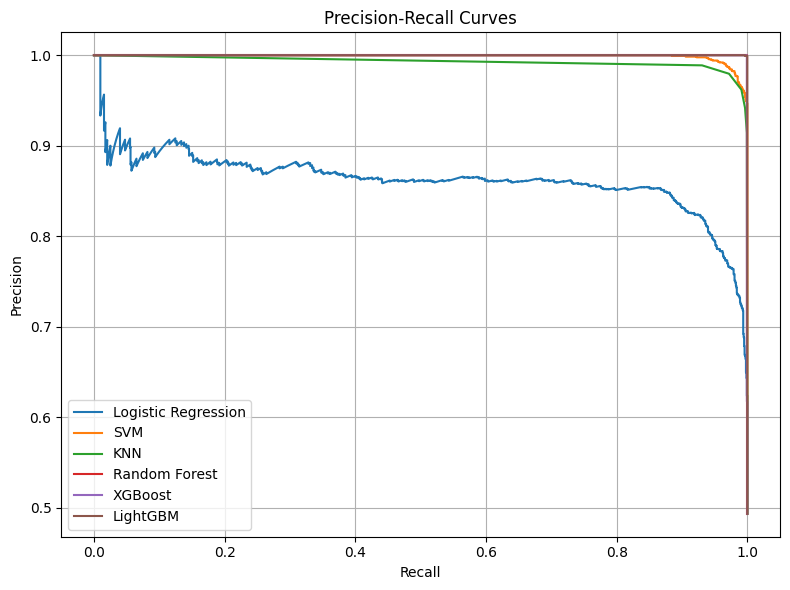

In [233]:
# Plot Precision-Recall curve for all models in one figure
def plot_precision_recall_curves(y_test, models, X_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.plot(recall, precision, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figures/precision_recall_curves.png')
    plt.show()
# Call the function to plot Precision-Recall curves
plot_precision_recall_curves(y_test, models, X_test)

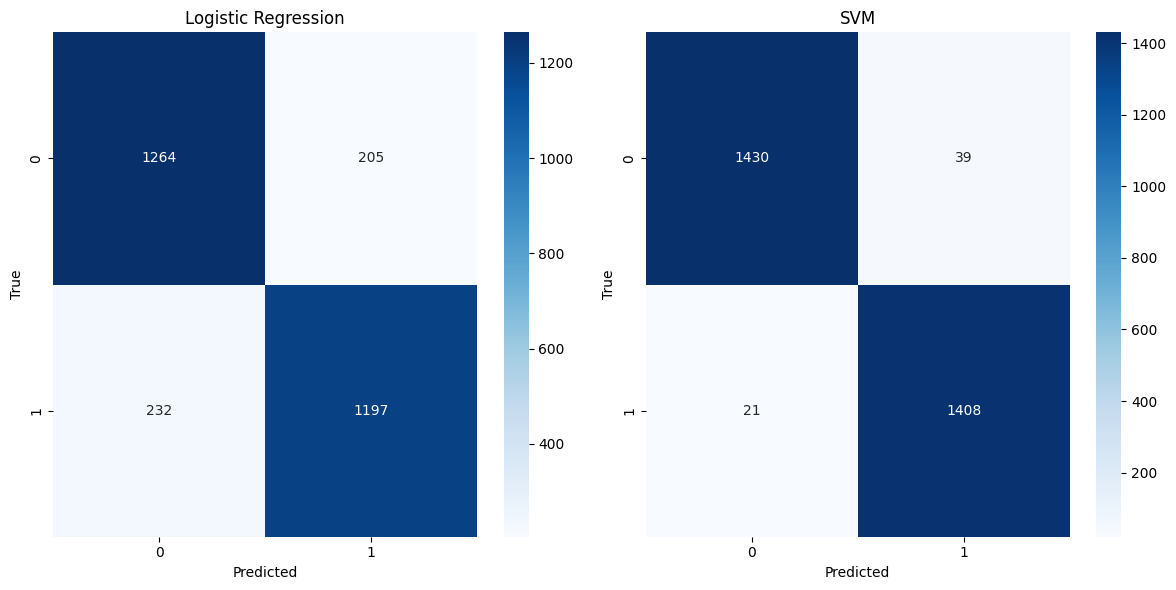

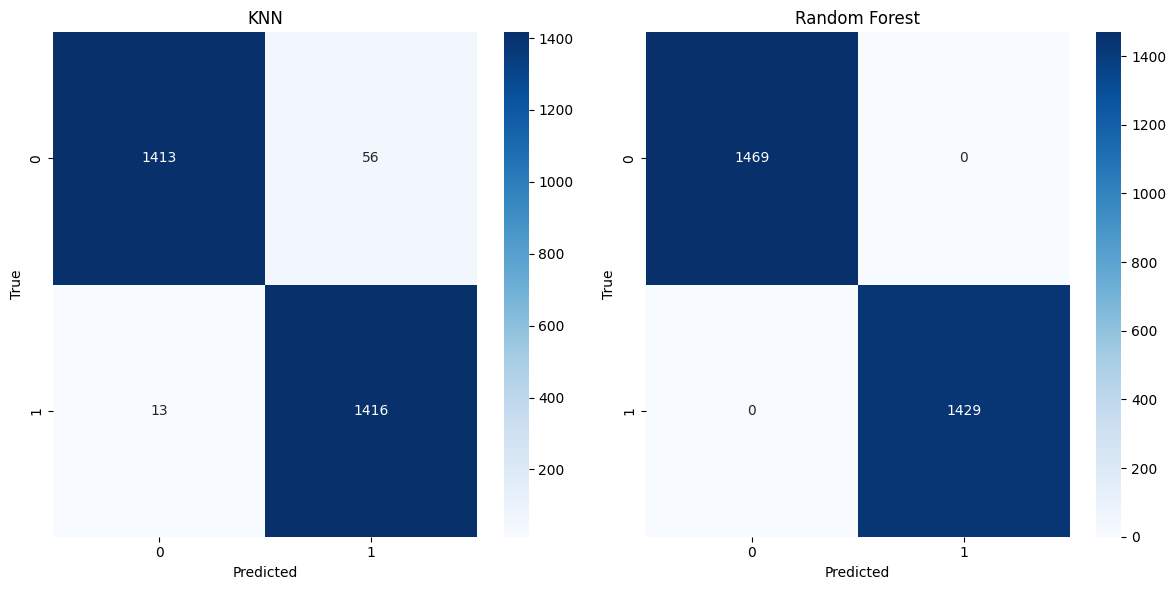

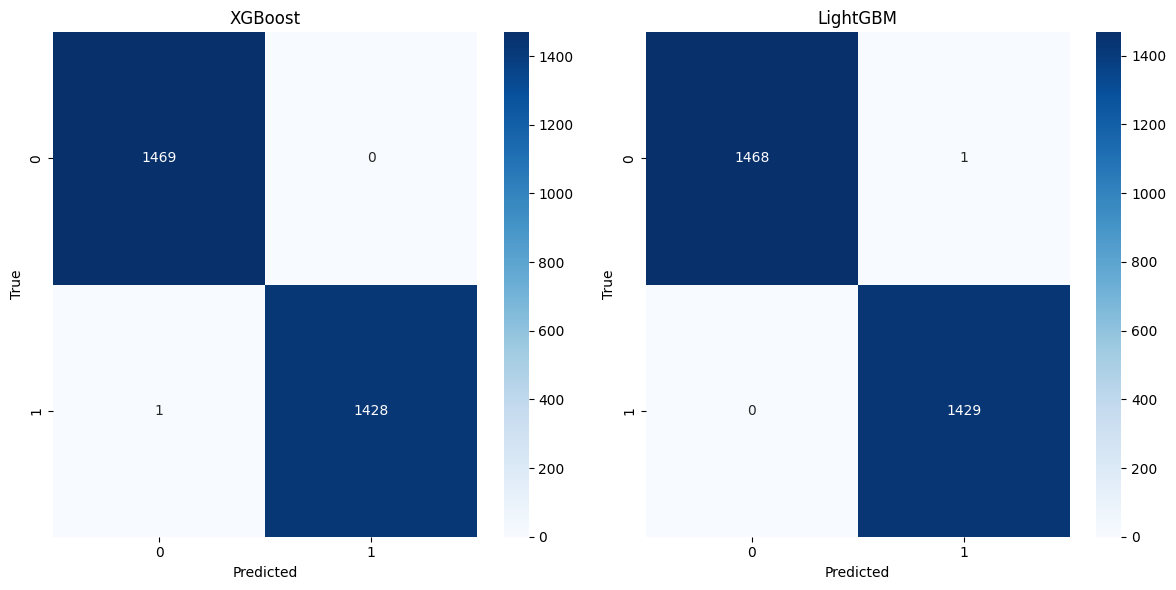

In [234]:
# Plot confusion matrix of all models in separate 1x2 plots
def plot_confusion_matrices_two_at_a_time(y_test, models, X_test):
    model_items = list(models.items())
    for i in range(0, len(model_items), 2):  # Iterate in steps of 2
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1-row, 2-column layout
        axes = axes.flatten()
        for j, (name, model) in enumerate(model_items[i:i+2]):  # Plot up to 2 models at a time
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[j], cmap='Blues')
            axes[j].set_title(name)
            axes[j].set_xlabel('Predicted')
            axes[j].set_ylabel('True')
        # Hide any unused subplot (if there are fewer than 2 models in the last iteration)
        if len(model_items[i:i+2]) < 2:
            axes[1].axis('off')
        plt.tight_layout()
        plt.show()

# Call the function to plot confusion matrices
plot_confusion_matrices_two_at_a_time(y_test, models, X_test)

In [235]:
# Save all models
for name, model in models.items():
    joblib.dump(model, f'models/{name.replace(" ", "_").lower()}.joblib')
    print(f"Model {name} saved as {name.replace(' ', '_').lower()}.joblib")

Model Logistic Regression saved as logistic_regression.joblib
Model SVM saved as svm.joblib
Model KNN saved as knn.joblib
Model Random Forest saved as random_forest.joblib
Model XGBoost saved as xgboost.joblib
Model LightGBM saved as lightgbm.joblib


## **7. Testing with Real World Data**

Evaluating the model trained with synthetic data by real world collected data.

In [236]:
# load and Evaluate the models with real_X_test and real_y_test
def evaluate_models_with_real_data(models, real_X_test, real_y_test):
    results = []  # List to store performance metrics for each model
    for name, model in models.items():
        y_pred = model.predict(real_X_test)
        # Use predict_proba to calculate ROC AUC if available
        y_proba = model.predict_proba(real_X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Calculate performance metrics
        accuracy = accuracy_score(real_y_test, y_pred)
        precision = precision_score(real_y_test, y_pred, zero_division=0)
        recall = recall_score(real_y_test, y_pred, zero_division=0)
        f1 = f1_score(real_y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(real_y_test, y_proba) if y_proba is not None else np.nan

        # Print performance metrics
        print(f"Model: {name}")
        print(f"  Accuracy : {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1 Score : {f1:.4f}")
        if not np.isnan(roc_auc):
            print(f"  ROC AUC  : {roc_auc:.4f}")
        else:
            print("  ROC AUC  : Not available")
        print("-" * 40)

        # Append results to list
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })

    return pd.DataFrame(results)
# Evaluate the models with real data
results_real_df = evaluate_models_with_real_data(trained_models, real_X_test, real_y_test)
# Save the results
results_real_df.to_csv('real_model_performance.csv', index=False)
# Print the results
print("Summary of model performance on real data:")
print(results_real_df)


Model: Logistic Regression
  Accuracy : 0.7619
  Precision: 0.8478
  Recall   : 0.6383
  F1 Score : 0.7283
  ROC AUC  : 0.8788
----------------------------------------
Model: SVM
  Accuracy : 0.8461
  Precision: 0.7647
  Recall   : 1.0000
  F1 Score : 0.8666
  ROC AUC  : 0.9762
----------------------------------------
Model: KNN
  Accuracy : 0.9153
  Precision: 0.8560
  Recall   : 0.9985
  F1 Score : 0.9218
  ROC AUC  : 0.9593
----------------------------------------
Model: Random Forest
  Accuracy : 0.7942
  Precision: 0.7084
  Recall   : 1.0000
  F1 Score : 0.8293
  ROC AUC  : 0.8676
----------------------------------------
Model: XGBoost
  Accuracy : 0.7945
  Precision: 0.7087
  Recall   : 1.0000
  F1 Score : 0.8295
  ROC AUC  : 0.8584
----------------------------------------
Model: LightGBM
  Accuracy : 0.7954
  Precision: 0.7097
  Recall   : 1.0000
  F1 Score : 0.8302
  ROC AUC  : 0.9037
----------------------------------------
Summary of model performance on real data:
          

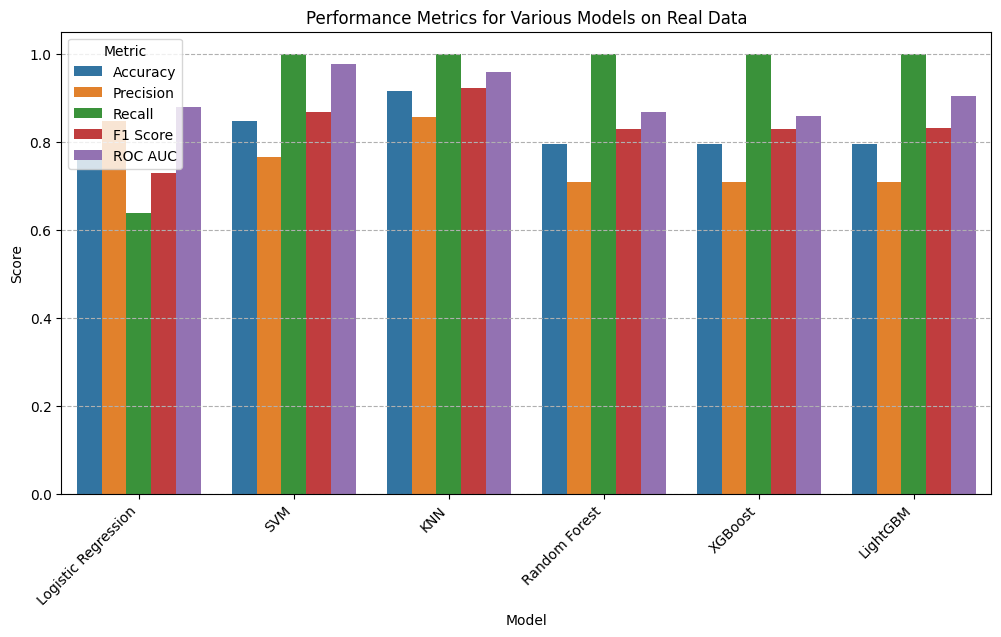

In [237]:
# Plot the performance metrics for real data
# Melt the results_df so that each row represents a metric score for a given model
results_melted = results_real_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models on Real Data")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
# Save the figure
plt.savefig('figures/real_model_performance.png')
# Show the plot
plt.show()

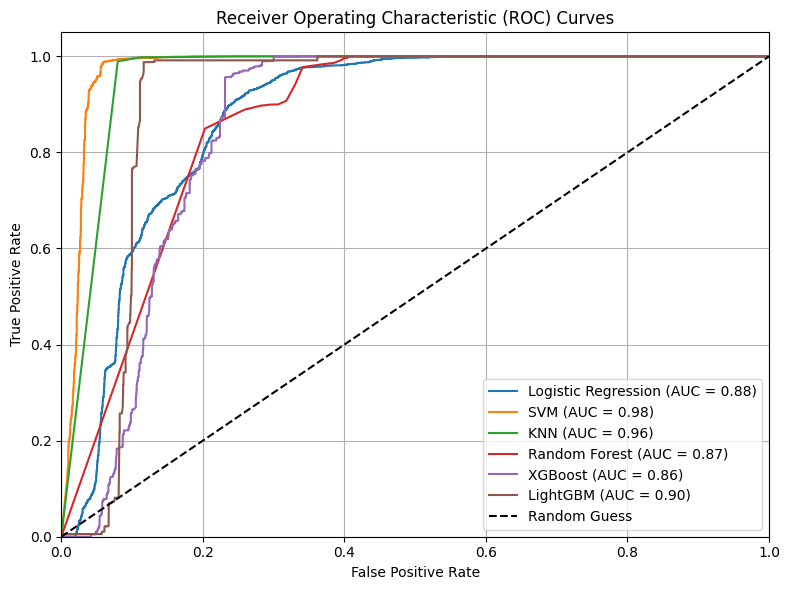

In [238]:
# ROC curve for all models in one figure on real data using previous function
plot_roc_curves(real_y_test, trained_models, real_X_test)

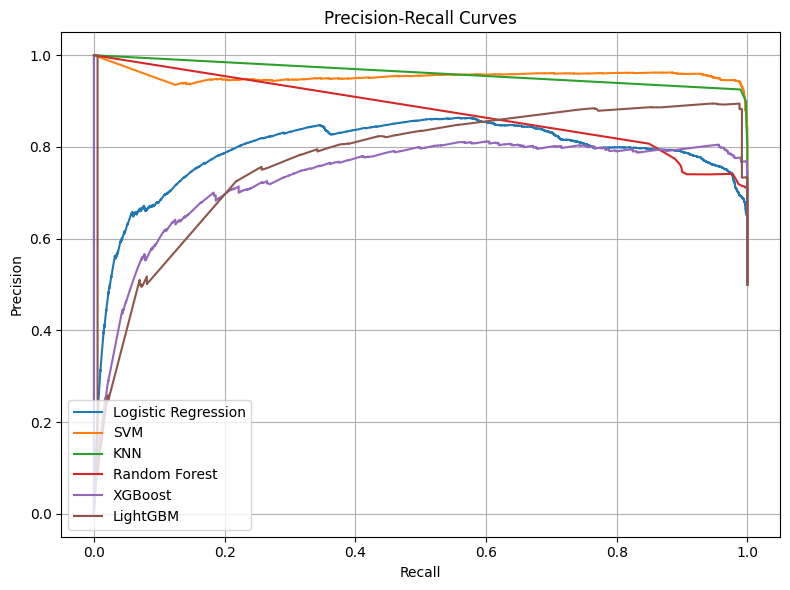

In [239]:
# Precision-Recall curve for all models in one figure on real data using previous function
plot_precision_recall_curves(real_y_test, models, real_X_test)

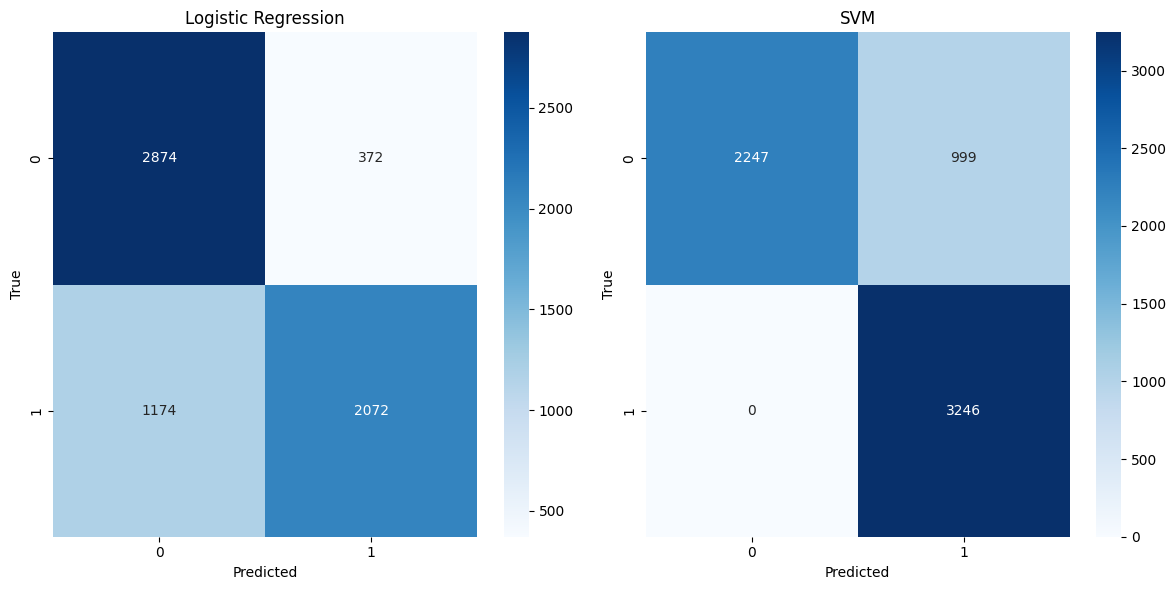

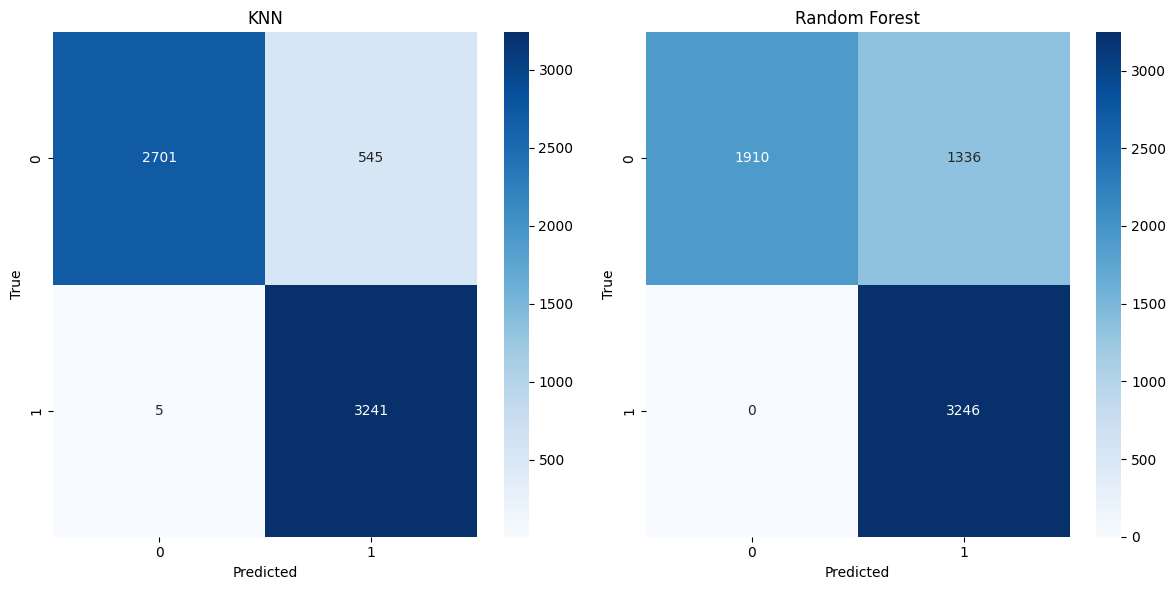

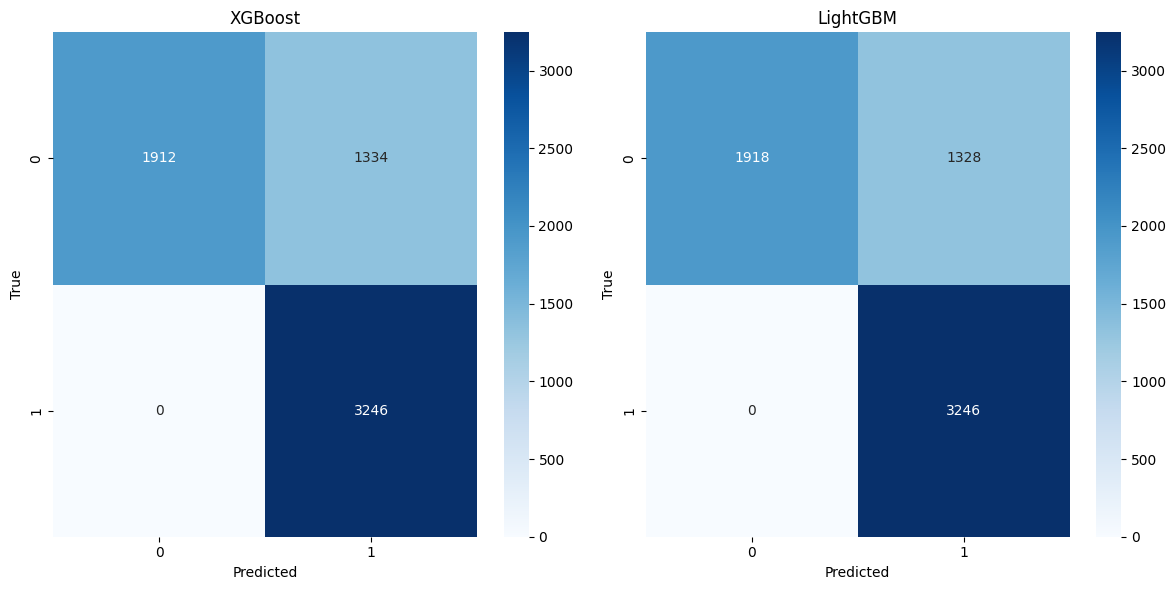

In [240]:
# Confusion matrix of all models in separate 1x2 plots on real data using previous function
plot_confusion_matrices_two_at_a_time(real_y_test, trained_models, real_X_test)

## **7. Stacking Classifier**

Combine top-performing models using a stacking classifier with Logistic Regression as the final estimator.

In [241]:
# # Create a Stacking Classifier with the 5 best models
# base_models = [
#     ('SVM', SVC(probability=True)),
#     ('KNN', KNeighborsClassifier()),
#     ('Random Forest', RandomForestClassifier()),
#     ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
#     ('LightGBM', LGBMClassifier(verbose=-1))
# ]

# stacking_model = StackingClassifier(
#     estimators=base_models,
#     final_estimator=LogisticRegression(),
#     cv=5
# )
# # Train the stacking model
# stacking_model.fit(X_train, y_train)
# # Evaluate the stacking model on the test set
# y_pred_stacking = stacking_model.predict(X_test)
# y_proba_stacking = stacking_model.predict_proba(X_test)[:, 1] if hasattr(stacking_model, "predict_proba") else None
# # Calculate performance metrics for the stacking model
# accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
# precision_stacking = precision_score(y_test, y_pred_stacking, zero_division=0)
# recall_stacking = recall_score(y_test, y_pred_stacking, zero_division=0)
# f1_stacking = f1_score(y_test, y_pred_stacking, zero_division=0)
# roc_auc_stacking = roc_auc_score(y_test, y_proba_stacking) if y_proba_stacking is not None else np.nan
# # Print performance metrics for the stacking model
# print(f"Stacking Model:")
# print(f"  Accuracy : {accuracy_stacking:.4f}")
# print(f"  Precision: {precision_stacking:.4f}")
# print(f"  Recall   : {recall_stacking:.4f}")
# print(f"  F1 Score : {f1_stacking:.4f}")
# if not np.isnan(roc_auc_stacking):
#     print(f"  ROC AUC  : {roc_auc_stacking:.4f}")
# else:
#     print("  ROC AUC  : Not available")
# print("-" * 40)

In [242]:
# # Save the final model
# joblib.dump(stacking_model, 'stacking_model.pkl')